This notebook walks through my approach to creating a salary prediction model using the data contained in the "DC_biotech_postings_May2020_to_July2021_subset.csv" file. It is intended to be read sequentially, as the order of analyses and methods are an exact reflection of how I approached the problem. 

The general organization of the notebook is:
- Data loading and orientation
- EDA
- Baseline modeling
- Model Improvement
- Incorporating text and NLP
- Exploring the job description text

In [1]:
%load_ext autoreload
%autoreload 2
import ssl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from gensim.models import Word2Vec

from nlp import clean_text, get_embs
from preprocessing import preprocess_job
from salary_prediction import SalaryModel


try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load and View Data

In [29]:
df = pd.read_csv('./data/DC_biotech_postings_May2020_to_July2021_subset.csv')
df.head()

,ID,PositionID,DateLastSeen,Date,Poster,Title,LocationCity,LocationCounty,LocationMSA,LocationState,...,Occupation2Code,Occupation2Name,Occupation6Code,Occupation6Name,Occupation8Code,Occupation8Name,SalaryAnnualEst,Certifications,ContentDescription,YearsofExperience
0,4195704761,2.343616e+09,2020-09-10,2020-01-21,Cedars-Sinai,Research Associate I - MAST - PI Dr. Mark Pime...,Los Angeles,Los Angeles County,Los Angeles-Long Beach-Anaheim,CA,...,19.0,"Life, Physical, and Social Science Occupation",194021.0,Biological Technicians,19402100.0,Biological Technicians,40000.0,NaN,When the work you do every single day has a cr...,0 to 2
1,4416958335,2.446415e+09,2020-07-25,2020-07-15,Partners Healthcare,Data Analyst,California City,Kern County,Bakersfield,CA,...,13.0,Business and Financial Operations Occupations,131111.0,Management Analysts,13111100.0,Management Analysts,NaN,NaN,When you're part of the team at Thermo Fisher ...,3 to 7
2,4452597202,2.497730e+09,2020-09-07,2020-08-05,Takeda,Medical Communications Expert Rare Immunology,Lexington,Middlesex County,Boston-Cambridge-Newton,MA,...,27.0,"Arts, Design, Entertainment, Sports, and Medi",273031.0,Public Relations Specialists,27303100.0,Public Relations Specialists,NaN,Doctor of Pharmacy (PharmD),""" OBJECTIVE The Global Medical Communications ...",3 to 7
3,4279428723,2.385148e+09,2020-05-17,2020-03-16,DIGNITY HEALTH,Lead Clinical Lab Scientist,San Bernardino,San Bernardino County,Riverside-San Bernardino-Ontario,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,112000.0,Clinical Laboratory Scientist License (CLS),Lead Clinical Lab Scientist Job ID 2020-104441...,8+
4,4484179402,2.530876e+09,2020-11-22,2020-09-01,Cedars-Sinai,Senior Accountant - Accounting,Encino,Los Angeles County,Los Angeles-Long Beach-Anaheim,CA,...,13.0,Business and Financial Operations Occupations,132011.0,Accountants and Auditors,13201101.0,Accountants,92000.0,Accounting,The Sr. Accountant is responsible for performi...,8+


- Redundant columns
- ID columns don't contain signal
- Ignore date

In [3]:
df = df.drop(['ID', 'PositionID', 'DateLastSeen', 'Date'], axis=1)
df

,Poster,Title,LocationCity,LocationCounty,LocationMSA,LocationState,JobType,EducationLevel,OccupationFunction,Occupation2Code,Occupation2Name,Occupation6Code,Occupation6Name,Occupation8Code,Occupation8Name,SalaryAnnualEst,Certifications,ContentDescription,YearsofExperience
0,Cedars-Sinai,Research Associate I - MAST - PI Dr. Mark Pime...,Los Angeles,Los Angeles County,Los Angeles-Long Beach-Anaheim,CA,"Permanent,Full-Time",Bachelor's Degree,Science / R&D,19.0,"Life, Physical, and Social Science Occupation",194021.0,Biological Technicians,19402100.0,Biological Technicians,40000.0,NaN,When the work you do every single day has a cr...,0 to 2
1,Partners Healthcare,Data Analyst,California City,Kern County,Bakersfield,CA,"Permanent,Full-Time",Bachelor's Degree,Finance / Accounting,13.0,Business and Financial Operations Occupations,131111.0,Management Analysts,13111100.0,Management Analysts,NaN,NaN,When you're part of the team at Thermo Fisher ...,3 to 7
2,Takeda,Medical Communications Expert Rare Immunology,Lexington,Middlesex County,Boston-Cambridge-Newton,MA,"Permanent,Full-Time",Master's Degree,Creative / Talent,27.0,"Arts, Design, Entertainment, Sports, and Medi",273031.0,Public Relations Specialists,27303100.0,Public Relations Specialists,NaN,Doctor of Pharmacy (PharmD),""" OBJECTIVE The Global Medical Communications ...",3 to 7
3,DIGNITY HEALTH,Lead Clinical Lab Scientist,San Bernardino,San Bernardino County,Riverside-San Bernardino-Ontario,CA,"Permanent,Full-Time",Master's Degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112000.0,Clinical Laboratory Scientist License (CLS),Lead Clinical Lab Scientist Job ID 2020-104441...,8+
4,Cedars-Sinai,Senior Accountant - Accounting,Encino,Los Angeles County,Los Angeles-Long Beach-Anaheim,CA,"Permanent,Full-Time",Bachelor's Degree,Finance / Accounting,13.0,Business and Financial Operations Occupations,132011.0,Accountants and Auditors,13201101.0,Accountants,92000.0,Accounting,The Sr. Accountant is responsible for performi...,8+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,AbbVie (New Company Separated from Abbott),HR Project Manager,Irvine,Orange County,Los Angeles-Long Beach-Anaheim,CA,"Permanent,Full-Time",Bachelor's Degree,Human Resources,11.0,Management Occupations,113121.0,Human Resources Managers,11312100.0,Human Resources Managers,100000.0,NaN,NaN,3 to 7
17276,Crispr Therapeutics,ManagerSr Manager Quality Management Systems,Cambridge,Middlesex County,Boston-Cambridge-Newton,MA,"Permanent,Full-Time",Bachelor's Degree,Manufacturing / Resources,11.0,Management Occupations,113051.0,Industrial Production Managers,11305101.0,Quality Control Systems Managers,138000.0,NaN,Job Description Job Description At CRISPR Ther...,8+
17277,Partners Healthcare,Member Experience Manager,Boston,Suffolk County,Boston-Cambridge-Newton,MA,NaN,Bachelor's Degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89000.0,NaN,Member Experience Manager - ( 3119308 ) Descri...,3 to 7
17278,CRISPR Therapeutics AG,NaN,Cambridge,Middlesex County,Boston-Cambridge-Newton,MA,"Permanent,Full-Time",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100000.0,NaN,""" In this role, the incumbent will report to t...",0 to 2


In [4]:
for col in df.columns:
    numfine = df[col].notna().sum()
    numna = df[col].isna().sum()
    numunique = len(df[col].unique())
    print(f'{col}: \n{numfine} valid, {numna} NA, {numunique} unique')
    

Poster: 
17280 valid, 0 NA, 75 unique
Title: 
15676 valid, 1604 NA, 10164 unique
LocationCity: 
16886 valid, 394 NA, 534 unique
LocationCounty: 
16921 valid, 359 NA, 66 unique
LocationMSA: 
16898 valid, 382 NA, 41 unique
LocationState: 
17280 valid, 0 NA, 2 unique
JobType: 
15621 valid, 1659 NA, 22 unique
EducationLevel: 
14997 valid, 2283 NA, 6 unique
OccupationFunction: 
11497 valid, 5783 NA, 16 unique
Occupation2Code: 
11497 valid, 5783 NA, 12 unique
Occupation2Name: 
11497 valid, 5783 NA, 12 unique
Occupation6Code: 
11497 valid, 5783 NA, 49 unique
Occupation6Name: 
11497 valid, 5783 NA, 49 unique
Occupation8Code: 
11497 valid, 5783 NA, 69 unique
Occupation8Name: 
11497 valid, 5783 NA, 69 unique
SalaryAnnualEst: 
11567 valid, 5713 NA, 303 unique
Certifications: 
6372 valid, 10908 NA, 910 unique
ContentDescription: 
15663 valid, 1617 NA, 13934 unique
YearsofExperience: 
16582 valid, 698 NA, 4 unique


- For location, keep state because no NA
- Drop occupation codes because contains same info as name
- Occupation names, especially 6 and 8, are similar, so may want to keep only one
- Many NAs in certifications. Drop or impute?
- Also, many unique certifications. Might be better to treat as text vs. categorical

In [5]:
df = df[df['SalaryAnnualEst'].notna()]
df = df.drop(['LocationCity', 'LocationCounty', 'LocationMSA', 'Occupation2Code', 'Occupation6Code', 'Occupation8Code'], axis=1)
df['Certifications'] = df['Certifications'].fillna('None')
salary = df['SalaryAnnualEst']
df.head()

,Poster,Title,LocationState,JobType,EducationLevel,OccupationFunction,Occupation2Name,Occupation6Name,Occupation8Name,SalaryAnnualEst,Certifications,ContentDescription,YearsofExperience
0,Cedars-Sinai,Research Associate I - MAST - PI Dr. Mark Pime...,CA,"Permanent,Full-Time",Bachelor's Degree,Science / R&D,"Life, Physical, and Social Science Occupation",Biological Technicians,Biological Technicians,40000.0,None,When the work you do every single day has a cr...,0 to 2
3,DIGNITY HEALTH,Lead Clinical Lab Scientist,CA,"Permanent,Full-Time",Master's Degree,NaN,NaN,NaN,NaN,112000.0,Clinical Laboratory Scientist License (CLS),Lead Clinical Lab Scientist Job ID 2020-104441...,8+
4,Cedars-Sinai,Senior Accountant - Accounting,CA,"Permanent,Full-Time",Bachelor's Degree,Finance / Accounting,Business and Financial Operations Occupations,Accountants and Auditors,Accountants,92000.0,Accounting,The Sr. Accountant is responsible for performi...,8+
5,PIH Health,EMERGENCY FINANCIAL REPRESENTATIVE OUTPATIENT ...,CA,"Permanent,Full-Time,Part-Time",GED/High School,Sales / Biz. Development,Office and Administrative Support Occupations,Customer Service Representatives,Patient Representatives,36000.0,Hospice and Palliative Care; Federal legislation,This position works under the direct supervisi...,0 to 2
7,Amgen,Sr Manager Manufacturing - Systems Lead,MA,"Permanent,Full-Time",Bachelor's Degree,Manufacturing / Resources,Management Occupations,Industrial Production Managers,Industrial Production Managers,143000.0,Total Quality Management certification (TQM),"Amgen Job ID: R-100726 Location: Woburn, MA, U...",8+


In [6]:
df = df.dropna()
df.shape

(4887, 13)

# EDA

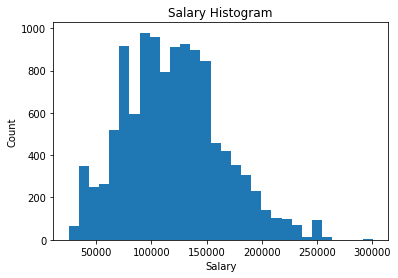

In [7]:
plt.hist(salary, bins=30)
plt.title('Salary Histogram')
plt.ylabel('Count')
plt.xlabel('Salary')
plt.show()

<AxesSubplot:title={'center':'SalaryAnnualEst'}, xlabel='LocationState'>

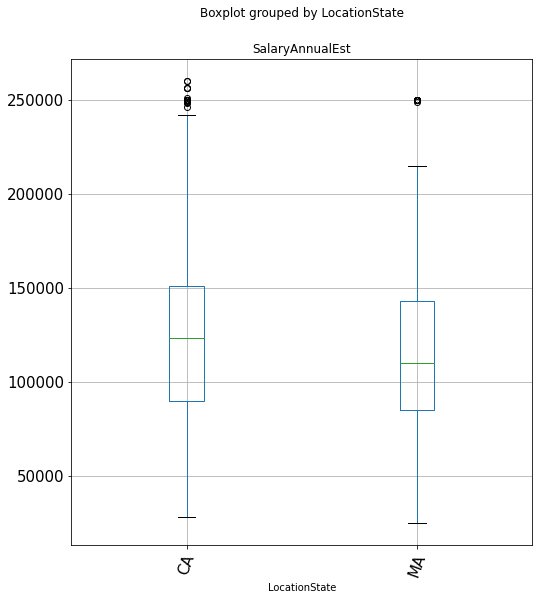

In [8]:
df.boxplot('SalaryAnnualEst', by='LocationState', figsize=(8,9), rot=70, fontsize=15)

<AxesSubplot:title={'center':'SalaryAnnualEst'}, xlabel='JobType'>

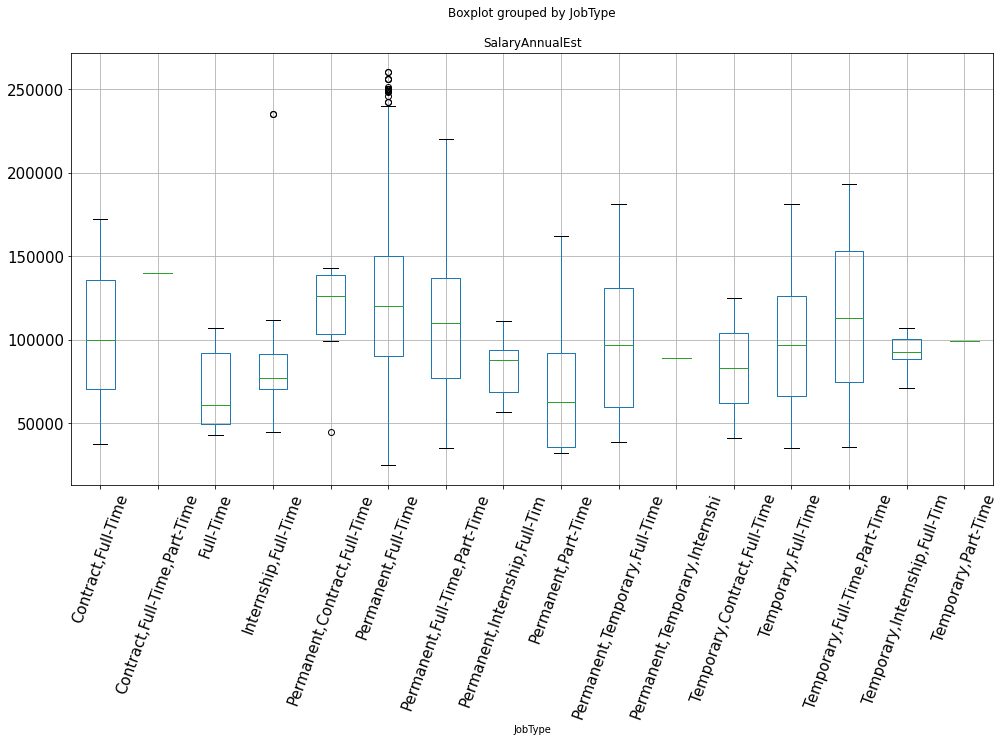

In [9]:
df.boxplot('SalaryAnnualEst', by='JobType', figsize=(16,8), rot=70, fontsize=15)

<AxesSubplot:title={'center':'SalaryAnnualEst'}, xlabel='Occupation2Name'>

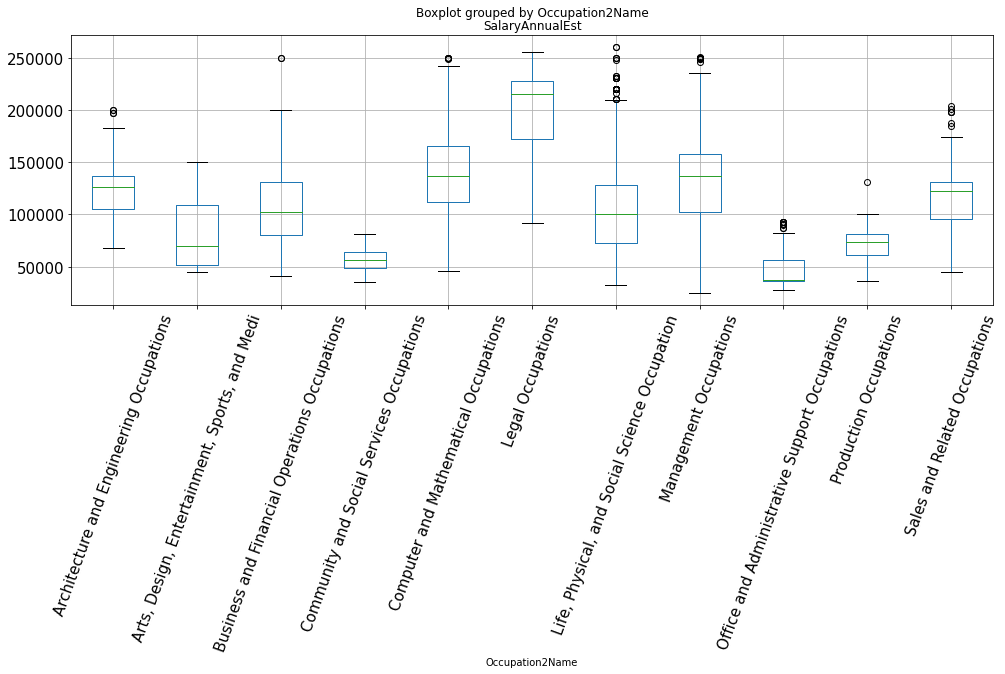

In [10]:
df.boxplot('SalaryAnnualEst', by='Occupation2Name', figsize=(16,5), rot=70, fontsize=15)

<AxesSubplot:title={'center':'SalaryAnnualEst'}, xlabel='Poster'>

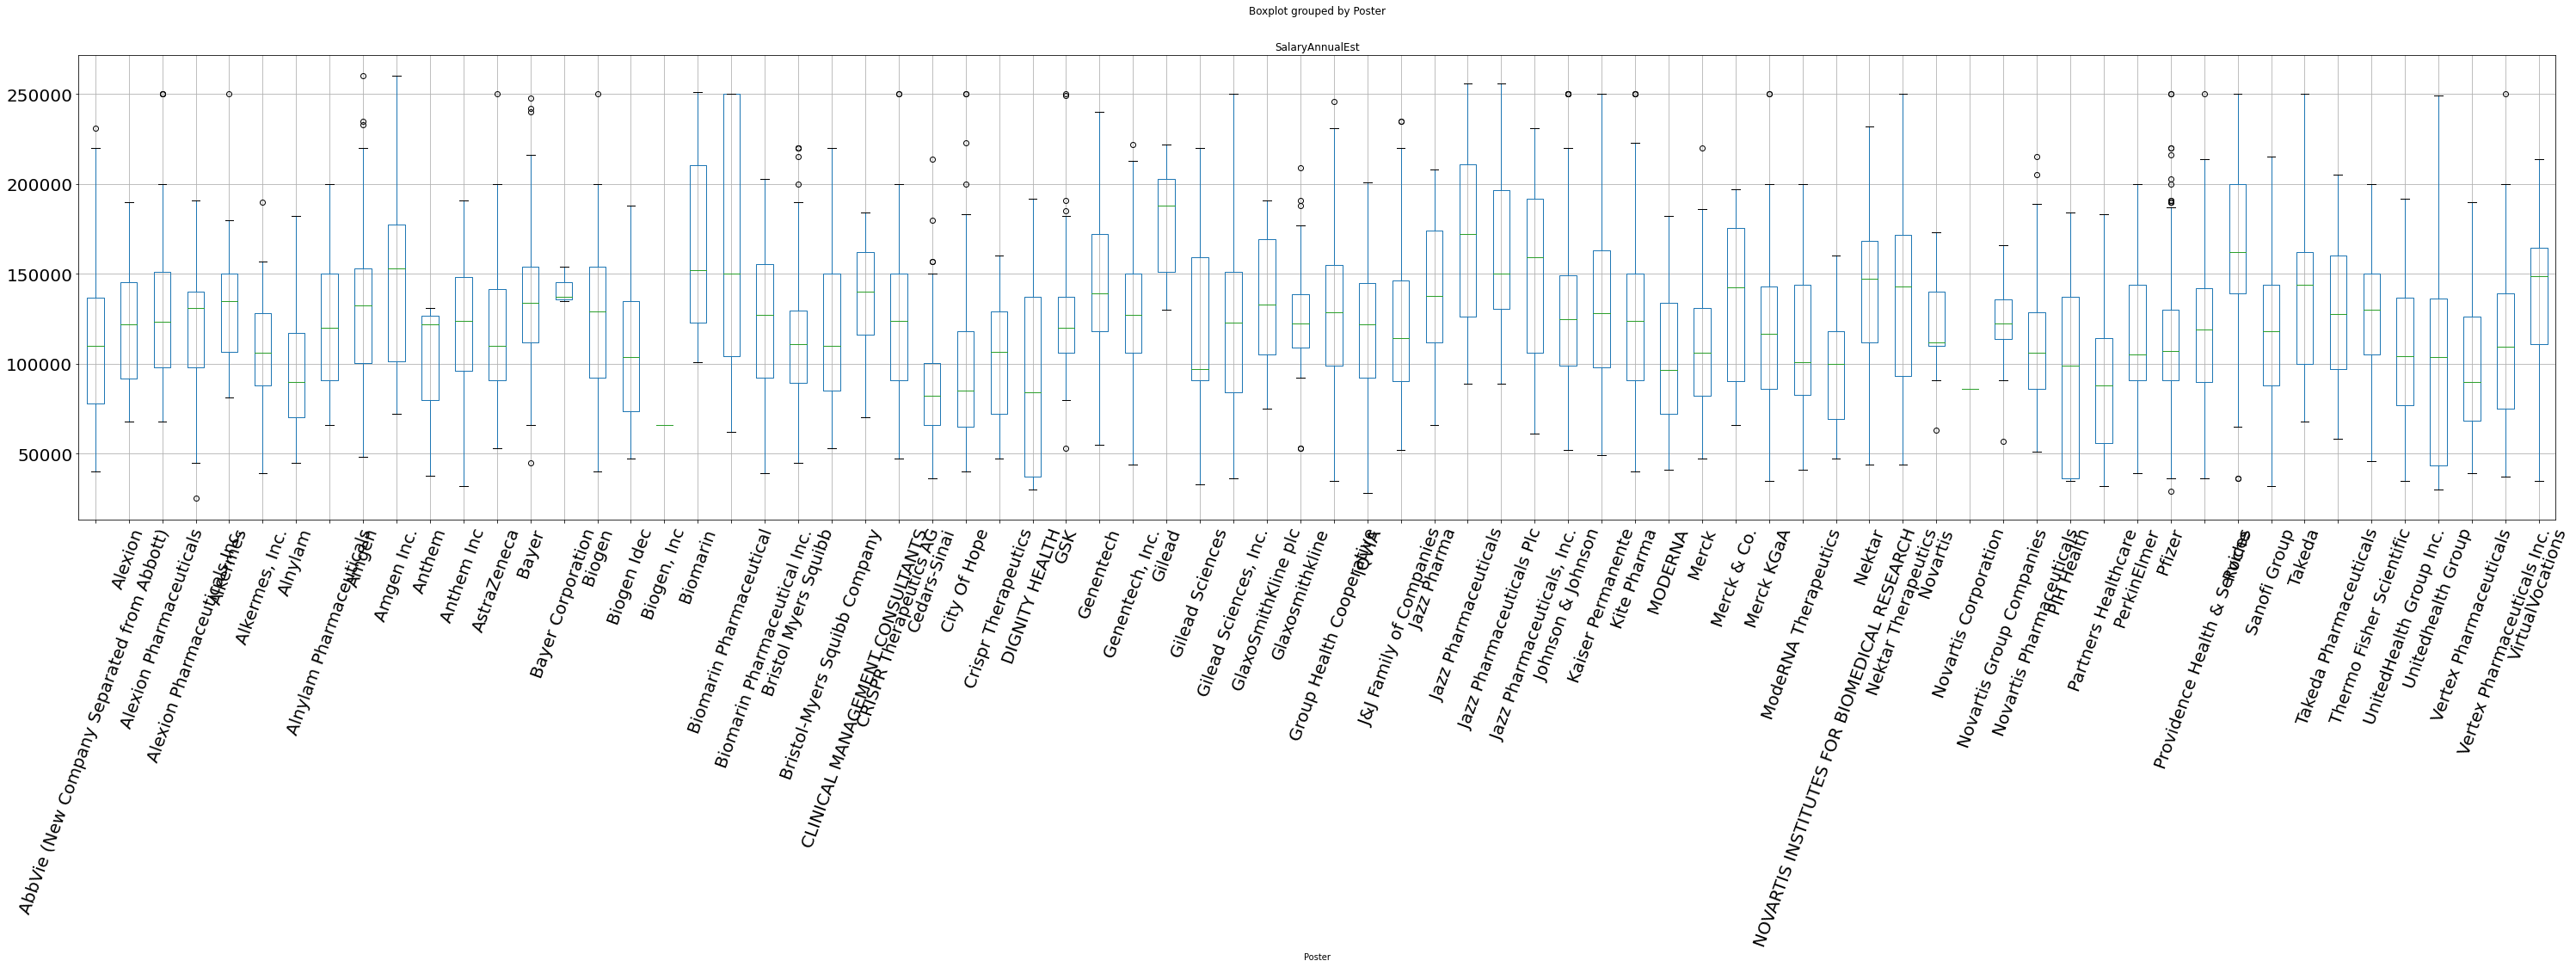

In [11]:
df.boxplot('SalaryAnnualEst', by='Poster', figsize=(50,10), rot=70, fontsize=20)

- Boxplots show some categorical variables vary with salary (Occupation Name) while others don't as much (State)
- Also, we see some categories have a low mean but a lot of high outliers (Occupation Name = Life, Physical and Social Science Occupation)

# Baseline Modeling

As a baseline salary prediction model, I'll start with a basic random forest using only categorical variables. Then, we can try to improve using NLP

In [12]:
salary = df['SalaryAnnualEst']

certs = df['Certifications']

df_categorical = df.drop(['Title', 'Certifications', 'ContentDescription', 'SalaryAnnualEst'], axis=1)

print(df_categorical.shape)
df_categorical.head()

(4887, 9)


,Poster,LocationState,JobType,EducationLevel,OccupationFunction,Occupation2Name,Occupation6Name,Occupation8Name,YearsofExperience
0,Cedars-Sinai,CA,"Permanent,Full-Time",Bachelor's Degree,Science / R&D,"Life, Physical, and Social Science Occupation",Biological Technicians,Biological Technicians,0 to 2
4,Cedars-Sinai,CA,"Permanent,Full-Time",Bachelor's Degree,Finance / Accounting,Business and Financial Operations Occupations,Accountants and Auditors,Accountants,8+
5,PIH Health,CA,"Permanent,Full-Time,Part-Time",GED/High School,Sales / Biz. Development,Office and Administrative Support Occupations,Customer Service Representatives,Patient Representatives,0 to 2
7,Amgen,MA,"Permanent,Full-Time",Bachelor's Degree,Manufacturing / Resources,Management Occupations,Industrial Production Managers,Industrial Production Managers,8+
8,CRISPR Therapeutics AG,MA,"Permanent,Full-Time",Bachelor's Degree,Science / R&D,Computer and Mathematical Occupations,Statisticians,Clinical Data Managers,3 to 7


- Because Occupation2Name, Occupation6Name, and Occupation8Name are highly correlated, let's try to just pick one to use for our model

In [13]:
name_vars = ['Occupation2Name', 'Occupation6Name', 'Occupation8Name']
df_categorical_noname = df_categorical.drop(name_vars, axis=1)
df_categorical_noname.head()

,Poster,LocationState,JobType,EducationLevel,OccupationFunction,YearsofExperience
0,Cedars-Sinai,CA,"Permanent,Full-Time",Bachelor's Degree,Science / R&D,0 to 2
4,Cedars-Sinai,CA,"Permanent,Full-Time",Bachelor's Degree,Finance / Accounting,8+
5,PIH Health,CA,"Permanent,Full-Time,Part-Time",GED/High School,Sales / Biz. Development,0 to 2
7,Amgen,MA,"Permanent,Full-Time",Bachelor's Degree,Manufacturing / Resources,8+
8,CRISPR Therapeutics AG,MA,"Permanent,Full-Time",Bachelor's Degree,Science / R&D,3 to 7


In [14]:
df_cat_noname_dummy = pd.get_dummies(df_categorical_noname)
df_cat_noname_dummy.head()

,Poster_AbbVie (New Company Separated from Abbott),Poster_Alexion,Poster_Alexion Pharmaceuticals,"Poster_Alexion Pharmaceuticals,Inc.",Poster_Alkermes,"Poster_Alkermes, Inc.",Poster_Alnylam,Poster_Alnylam Pharmaceuticals,Poster_Amgen,Poster_Amgen Inc.,...,OccupationFunction_Manufacturing / Resources,OccupationFunction_Marketing / PR,OccupationFunction_Medical / Health,OccupationFunction_Operations / Logistics,OccupationFunction_Sales / Biz. Development,OccupationFunction_Science / R&D,OccupationFunction_Social Services,YearsofExperience_0 to 2,YearsofExperience_3 to 7,YearsofExperience_8+
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
7,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


### No Occupation Name

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_cat_noname_dummy, salary, test_size = .3, random_state = 10)
rf = RandomForestRegressor(random_state=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
print(f'R2 Score: {r2}, MSE: {mse}')
top_features_idx = list(reversed(list(np.argsort(rf.feature_importances_))))

for i, idx in enumerate(top_features_idx):
    print(rf.feature_importances_[idx], df_cat_noname_dummy.columns[idx])
    

R2 Score: 0.5732555157328165, MSE: 828552808.3228111
0.32658806433953325 YearsofExperience_8+
0.08369129950885833 YearsofExperience_0 to 2
0.03996729497057675 EducationLevel_GED/High School
0.03860368617532473 OccupationFunction_Administration / Clerical
0.037089733150932495 YearsofExperience_3 to 7
0.021891934417835043 OccupationFunction_Legal
0.021289189924536777 OccupationFunction_Information Technology
0.018983079291508012 OccupationFunction_Medical / Health
0.017691486554957704 OccupationFunction_Science / R&D
0.017612075364131046 EducationLevel_Bachelor's Degree
0.014929740002401054 OccupationFunction_Executive Management
0.014130925607103806 Poster_Roche
0.010285270849211416 EducationLevel_Doctoral Degree
0.009751833817049815 LocationState_MA
0.009717964851245924 OccupationFunction_Marketing / PR
0.00970183835922444 Poster_Bayer
0.009661554679826323 Poster_Biomarin Pharmaceutical
0.009357122363729249 Poster_City Of Hope
0.009208357476365774 EducationLevel_Master's Degree
0.00907

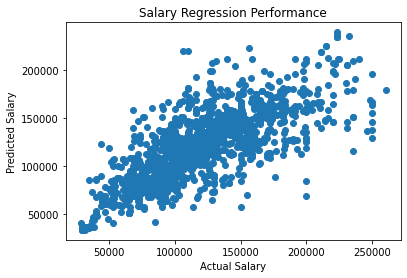

In [16]:
plt.scatter(y_test, preds)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Salary Regression Performance')
plt.show()

# Improving Model

### All Occupation Name Variables

In [17]:
df_categorical_dummy = pd.get_dummies(df_categorical)

X_train, X_test, y_train, y_test = train_test_split(df_categorical_dummy, salary, test_size = .3, random_state = 10)
rf = RandomForestRegressor(random_state=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
print(f'R2 Score: {r2}, MSE: {mse}')

top_features_idx = list(reversed(list(np.argsort(rf.feature_importances_))))

for i, idx in enumerate(top_features_idx):
    print(rf.feature_importances_[idx], df_categorical_dummy.columns[idx])

R2 Score: 0.7156533194306154, MSE: 552077998.4481927
0.31118029483795606 YearsofExperience_8+
0.09235862013684581 Occupation2Name_Office and Administrative Support Occupations
0.07716941443624775 YearsofExperience_0 to 2
0.03526835721056436 YearsofExperience_3 to 7
0.019827692951648334 Occupation2Name_Management Occupations
0.01888556981037155 Occupation8Name_Regulatory Affairs Managers
0.011819149793279327 EducationLevel_Bachelor's Degree
0.011668673182304842 Poster_Roche
0.010735565424941392 LocationState_MA
0.010649658443214359 EducationLevel_Doctoral Degree
0.010497605124199753 LocationState_CA
0.01036615988584689 Occupation2Name_Business and Financial Operations Occupations
0.010168004052142646 Occupation6Name_Biological Technicians
0.009955603485791895 Occupation2Name_Computer and Mathematical Occupations
0.008889755304131232 Occupation8Name_Biological Technicians
0.008640933565308172 OccupationFunction_Information Technology
0.008388536087170108 Poster_Bayer
0.007880802523297904

0.0006996084164444091 Poster_Alexion
0.0006891402273528838 Occupation8Name_Treasurers and Controllers
0.000662908315050699 Occupation8Name_Computer Systems Analysts
0.0006525506961231757 Occupation2Name_Architecture and Engineering Occupations
0.0006401675555427238 Occupation8Name_Clinical Data Managers
0.0006341067502724263 Occupation8Name_Statisticians
0.0006288798585226363 Occupation8Name_Supply Chain Managers
0.0006160280303499093 Occupation6Name_Industrial Production Managers
0.0005801084739862642 Occupation8Name_Operations Research Analysts
0.0005546808293419559 Poster_Novartis Group Companies
0.0005505394644223841 Occupation8Name_Public Relations Specialists
0.0005207132017833298 Occupation8Name_Computer Programmers
0.0005134678132142217 EducationLevel_Associate Level
0.0005093132078100828 Occupation8Name_Network and Computer Systems Administrators
0.0004988087225437463 Occupation8Name_Industrial Production Managers
0.0004922346744997682 Occupation6Name_Chemists
0.00047898763802

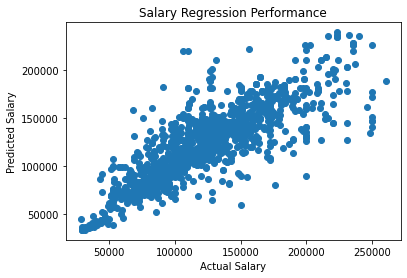

In [18]:
plt.scatter(y_test, preds)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Salary Regression Performance')
plt.show()

### Single Occupation Name Variables

In [19]:
df_categorical_2 = df_categorical.drop(['Occupation6Name', 'Occupation8Name'], axis=1)

In [20]:
df_categorical_dummy = pd.get_dummies(df_categorical_2)

X_train, X_test, y_train, y_test = train_test_split(df_categorical_dummy, salary, test_size = .3, random_state = 10)
rf = RandomForestRegressor(random_state=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
print(f'R2 Score: {r2}, MSE: {mse}')

top_features_idx = list(reversed(list(np.argsort(rf.feature_importances_))))

for i, idx in enumerate(top_features_idx):
    print(rf.feature_importances_[idx], df_categorical_dummy.columns[idx])

R2 Score: 0.6451096008321143, MSE: 689043321.5142722
0.314663028647231 YearsofExperience_8+
0.094378473289713 Occupation2Name_Office and Administrative Support Occupations
0.07586399631710178 YearsofExperience_0 to 2
0.04234795481795341 YearsofExperience_3 to 7
0.028678811344050807 Occupation2Name_Management Occupations
0.02066634780691868 OccupationFunction_Science / R&D
0.01632594025704757 Occupation2Name_Life, Physical, and Social Science Occupation
0.016164221655040445 OccupationFunction_Information Technology
0.015624664758154046 EducationLevel_Bachelor's Degree
0.014819046149931143 Occupation2Name_Computer and Mathematical Occupations
0.014774786493983992 Poster_Roche
0.014515875197009477 OccupationFunction_Medical / Health
0.01159763677223353 Occupation2Name_Business and Financial Operations Occupations
0.011076968079747831 Occupation2Name_Legal Occupations
0.0107760725812978 OccupationFunction_Legal
0.010759095654499524 EducationLevel_Doctoral Degree
0.010386721505936117 Locati

In [21]:
df_categorical_6 = df_categorical.drop(['Occupation2Name', 'Occupation8Name'], axis=1)

df_categorical_dummy = pd.get_dummies(df_categorical_6)

X_train, X_test, y_train, y_test = train_test_split(df_categorical_dummy, salary, test_size = .3, random_state = 10)
rf = RandomForestRegressor(random_state=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
print(f'R2 Score: {r2}, MSE: {mse}')

top_features_idx = list(reversed(list(np.argsort(rf.feature_importances_))))

for i, idx in enumerate(top_features_idx):
    print(rf.feature_importances_[idx], df_categorical_dummy.columns[idx])

R2 Score: 0.6631240986903182, MSE: 654066975.3839376
0.3145268505632414 YearsofExperience_8+
0.08076441335199423 YearsofExperience_0 to 2
0.04427782282302504 Occupation6Name_Customer Service Representatives
0.0369606416277472 OccupationFunction_Administration / Clerical
0.035513200458341436 YearsofExperience_3 to 7
0.01991977028287577 Occupation6Name_Biological Technicians
0.016604892363943528 Occupation6Name_Medical and Health Services Managers
0.0146902595656069 OccupationFunction_Information Technology
0.014062488458818244 EducationLevel_Bachelor's Degree
0.013100109585453039 Occupation6Name_Lawyers
0.012807258165834206 Poster_Roche
0.01276683436959662 Occupation6Name_Computer and Information Systems Managers
0.009696250940725917 EducationLevel_Doctoral Degree
0.009140070242634316 Poster_Biomarin Pharmaceutical
0.009088125387270031 LocationState_MA
0.00898902161950914 Poster_Bayer
0.008627106795354847 Occupation6Name_First-Line Supervisors of Production and Operating Workers
0.00856

1.6336111427642528e-05 JobType_Temporary,Part-Time
1.4147566298822304e-05 JobType_Permanent,Contract,Full-Time
1.388812802728019e-05 JobType_Permanent,Temporary,Internshi
2.219925587596952e-06 JobType_Temporary,Full-Time,Part-Time
0.0 Poster_Biogen, Inc
0.0 JobType_Contract,Full-Time,Part-Time
0.0 Poster_Novartis Corporation


In [22]:
df_categorical_8 = df_categorical.drop(['Occupation2Name', 'Occupation6Name'], axis=1)

df_categorical_dummy = pd.get_dummies(df_categorical_8)

X_train, X_test, y_train, y_test = train_test_split(df_categorical_dummy, salary, test_size = .3, random_state = 10)
rf = RandomForestRegressor(random_state=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
print(f'R2 Score: {r2}, MSE: {mse}')

top_features_idx = list(reversed(list(np.argsort(rf.feature_importances_))))

for i, idx in enumerate(top_features_idx):
    print(rf.feature_importances_[idx], df_categorical_dummy.columns[idx])

R2 Score: 0.7019193447442498, MSE: 578743424.0490966
0.31114216074104295 YearsofExperience_8+
0.080309911615953 YearsofExperience_0 to 2
0.03747104877756306 EducationLevel_GED/High School
0.03518016374907378 OccupationFunction_Administration / Clerical
0.034676169094744656 YearsofExperience_3 to 7
0.023639570348910736 Occupation8Name_Regulatory Affairs Managers
0.018884165771718843 Occupation8Name_Biological Technicians
0.017898193351857206 Occupation8Name_Medical and Health Services Managers
0.01549993550007761 OccupationFunction_Information Technology
0.013309204842472682 Occupation8Name_Computer and Information Systems Managers
0.013134012481220097 EducationLevel_Bachelor's Degree
0.011825795635083118 OccupationFunction_Legal
0.011172607933298858 Poster_Roche
0.010163935735700659 Occupation8Name_Lawyers
0.009850612673002504 LocationState_CA
0.009591003251720057 OccupationFunction_Medical / Health
0.009328447284743567 EducationLevel_Doctoral Degree
0.008886627968420935 Poster_Bayer
0

0.00017232846498718276 Poster_Biogen Idec
0.0001704023344076238 Occupation8Name_Technical Writers
0.00016634939687316532 JobType_Permanent,Temporary,Full-Time
0.00013096994869268795 Occupation8Name_Regulatory Affairs Specialists
0.00012391564311030497 JobType_Internship,Full-Time
0.000122064109958437 Occupation8Name_Materials Scientists
0.00012046154335684825 Occupation8Name_Geographic Information Systems Technicians
0.00011312446459120662 Poster_Bayer Corporation
6.646517901436272e-05 Occupation8Name_Training and Development Managers
3.807889243391485e-05 JobType_Permanent,Internship,Full-Tim
3.372854760830027e-05 Occupation8Name_Biostatisticians
2.732977996618969e-05 JobType_Full-Time
2.5263872371621523e-05 JobType_Temporary,Part-Time
2.3008946594296847e-05 JobType_Temporary,Internship,Full-Tim
1.3498556537198952e-05 JobType_Temporary,Contract,Full-Time
1.1475107388806123e-05 JobType_Permanent,Temporary,Internshi
1.0170386294200658e-05 JobType_Temporary,Full-Time,Part-Time
4.33825561

- Best performance from keeping all Occupation Name variables, but if we were to only keep one, keep Occupation8Name

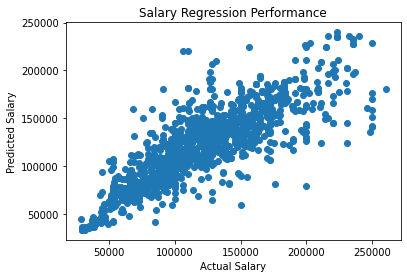

In [23]:
plt.scatter(y_test, preds)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Salary Regression Performance')
plt.show()

### Adding Certifications as a categorical variable

In [24]:
df_categorical['Certifications'] = certs

df_categorical_dummy = pd.get_dummies(df_categorical)

X_train, X_test, y_train, y_test = train_test_split(df_categorical_dummy, salary, test_size = .3, random_state = 10)
rf = RandomForestRegressor(random_state=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
print(f'R2 Score: {r2}, MSE: {mse}')

top_features_idx = list(reversed(list(np.argsort(rf.feature_importances_))))

for i, idx in enumerate(top_features_idx):
    print(rf.feature_importances_[idx], df_categorical_dummy.columns[idx])

R2 Score: 0.7414140778063868, MSE: 502061772.1496303
0.30137939365698513 YearsofExperience_8+
0.0901165276093047 Occupation2Name_Office and Administrative Support Occupations
0.07502857144797107 YearsofExperience_0 to 2
0.03711370084632658 YearsofExperience_3 to 7
0.01950430306111533 Occupation2Name_Management Occupations
0.018222923271542752 Occupation8Name_Regulatory Affairs Managers
0.014606621023814659 Certifications_Doctor of Pharmacy (PharmD)
0.01104679979905495 EducationLevel_Bachelor's Degree
0.010615072015587207 LocationState_CA
0.010328617240077075 Occupation2Name_Computer and Mathematical Occupations
0.010214015528197406 EducationLevel_Doctoral Degree
0.010011038929025525 Occupation8Name_Biological Technicians
0.00936328120599706 Poster_Roche
0.00934330759948413 Occupation2Name_Business and Financial Operations Occupations
0.009047305550334664 Certifications_Doctor of Pharmacy (PharmD); Good Clinical Practice (GCP)
0.008749726852577933 LocationState_MA
0.008728539558792216 O

0.0007679855088230412 Occupation6Name_Computer and Information Research Scientists
0.0007629729554806021 Occupation6Name_Operations Research Analysts
0.0007153711523034981 Occupation6Name_Financial Managers
0.0007010098719043799 Poster_Partners Healthcare
0.0007004326548365365 OccupationFunction_Engineering / QA
0.0006827331521756692 Occupation8Name_Computer Systems Analysts
0.0006814855743514582 Poster_Alkermes, Inc.
0.000670721511729446 Certifications_Emergency Medical Dispatch (EMD)
0.0006667702949481061 Occupation6Name_Managers, All Other
0.0006623800960785376 Occupation6Name_Industrial Engineers
0.0006613193208664327 Occupation6Name_Public Relations and Fundraising Managers
0.0006611922097684529 Occupation8Name_Statisticians
0.000645706291351128 Poster_Biomarin Pharmaceutical Inc.
0.000638349210716042 Poster_Merck
0.0006260286187057712 Occupation6Name_Network and Computer Systems Administrators
0.0006084621701003475 Certifications_Certification in Clinical Molecular Genetics (CMG)

0.0001484684589182791 JobType_Internship,Full-Time
0.00014787829566149512 Certifications_Commodity Trading Advisor (CTA); Good Clinical Practice (GCP)
0.0001451781764890526 Certifications_Salesforce.com certified
0.00014350605430382202 Certifications_Accounting
0.000142832163205236 Certifications_Certified Ethical Hacker  (CEH); Certified Information Systems Security Professional (CISSP); Global Information Assurance Certification  (GIAC); SANS Certif
0.00014023618179442616 Poster_Merck & Co.
0.0001306144440389187 Poster_UnitedHealth Group Inc.
0.00013022577730541178 Certifications_GIAC Certified Project Manager (GCPM)
0.0001284916119139208 Poster_PIH Health
0.0001255614853213274 Certifications_Good Laboratory Practices certifications (GLP); Certified Quality Auditor (CQA)
0.00012328847411985648 Certifications_Project Management Professional (PMP); Good Clinical Practice (GCP)
0.00012254479406567173 Occupation6Name_Business Operations Specialists, All Other
0.00012215041707279683 Occup

3.323218197412855e-05 Certifications_American Board of Imaging Informatics (ABII)
3.3221119786857394e-05 Certifications_Certified Public Accountant (CPA); Energy Risk Professional (ERP)
3.294445849357169e-05 Occupation8Name_Purchasing Agents, Except Wholesale, Retail, and Farm Products
3.243138050003731e-05 Certifications_EPA certification (EPA); Occupational Safety & Health Administration Certification (OSHA); American Society for Testing and Materials (ASTM)
3.241561880576135e-05 Certifications_Information Assurance Management (IAM)
3.224835968323246e-05 Occupation8Name_Training and Development Managers
3.215172572193617e-05 Certifications_Clinical Research Coordinator (CRC); Good Clinical Practice (GCP)
3.207854428265467e-05 Certifications_Certified Scrum Master (CSM); Scaled agile framework
3.158110130397134e-05 Certifications_Clinical Laboratory Scientist License (CLS); Doctor of Pharmacy (PharmD)
3.154982703452767e-05 Certifications_American Production and Inventory Control Socie

1.2069160304953029e-05 JobType_Temporary,Part-Time
1.1843260963249721e-05 Certifications_Certified Quality Engineer (CQE); Certified Reliability Engineer (CRE); Certified Quality Auditor (CQA); Medical Device Directive Certification (MDD); Profes
1.1821462897229161e-05 Certifications_Certified Professional in Healthcare Quality (CPHQ); Professional in Healthcare Quality
1.1606233069446259e-05 Certifications_Advanced Cardiac Life Support (ACLS)
1.1433109880930628e-05 Certifications_Continuing Education (CE); Doctor of Pharmacy (PharmD)
1.1384062431964202e-05 Certifications_Certified Diabetes Educator (CDE)
1.0631581854712554e-05 Certifications_Clinical Laboratory Scientist License (CLS); Medical Laboratory Scientist (MLS)
1.0069919795789431e-05 Certifications_Project Management Professional (PMP); Professional in Human Resources (PHR); Senior Professional in Human Resources (SPHR); Acquisition operations
1.0054870859074153e-05 Certifications_Project Management Professional (PMP); Doctor

2.1152596705340453e-06 Certifications_Professional in Human Resources (PHR); Senior Professional in Human Resources (SPHR); AIRS Certification
2.0862529132411596e-06 Certifications_Certified Management Accountant (CMA); Certified Public Accountant (CPA); Energy Risk Professional (ERP); Accounting
2.0425604335055123e-06 Certifications_Design for Manufacturability and Assembly (DFM, DFA); Design for Six Sigma (DFSS)
2.0365417837748327e-06 Certifications_Certified Professional in Supply Management (CPSM); Department of Health and Human Services (HHS)
2.0014819730949477e-06 Occupation8Name_Compliance Officers
1.8625194400127338e-06 Certifications_Society of Clinical Research Associates (SoCRA); Good Clinical Practice (GCP)
1.8105168052157047e-06 Certifications_Certified in Integrated Resource Management (CIRM); Certified in Production and Inventory Management (CPIM)
1.807787823609957e-06 Certifications_IAHCSMM Certification
1.7854341739357453e-06 Certifications_Good Laboratory Practices ce

0.0 Certifications_Project Management Professional (PMP); Six Sigma Green Belt - LEAN
0.0 Certifications_Six Sigma Green Belt (SSGB); Six Sigma Yellow Belt
0.0 Certifications_Project Management Professional (PMP); Water Safety Instructor (WSI); Good Clinical Practice (GCP)
0.0 Certifications_Strategic Planning Professional (SPP)
0.0 Certifications_Regulatory Affairs Certification (RAC)
0.0 Certifications_Material Handling Equipment (MHE)
0.0 Certifications_Robotics Process Automation (RPA); Talent analytics
0.0 Certifications_Medical Expense Initiatives program (MEI); Good Clinical Practice (GCP)
0.0 JobType_Contract,Full-Time,Part-Time
0.0 Certifications_Physical Security Professional (PSP); Doctor of Pharmacy (PharmD)
0.0 Certifications_Nuclear Medicine ABNM
0.0 Certifications_Professional Selling Skills (PSS); Driver's License
0.0 Certifications_Secret security clearance
0.0 Certifications_Project Management Professional (PMP); Six Sigma certification
0.0 Certifications_Professional

0.0 Certifications_Adult Nurse Practitioner (ANP); Doctor of Pharmacy (PharmD)
0.0 Certifications_Accredited Senior Appraiser (ASA)
0.0 Certifications_Accredited Management Accountant (AMA)
0.0 Certifications_Clinical Laboratory Scientist License (CLS); Molecular Diagnostics
0.0 Certifications_Certified Registered Nurse (RNC); Hospice and Palliative Care; Occupational Safety & Health Administration Certification (OSHA)
0.0 Certifications_Clinical Research Associate (CRA)
0.0 Certifications_Clinical Research Associate (CRA); Clinical Research Coordinator (CRC); Good Clinical Practice (GCP)
0.0 Certifications_Clinical Research Coordinator (CRC)
0.0 Certifications_Clinical Research Coordinator (CRC); Certification in Ethics (NIH)
0.0 Certifications_Commodity Trading Advisor (CTA); American Board of Toxicology  (DABT); Good Laboratory Practices certifications (GLP); Doctor of Veterinary Medicine (DVM)
0.0 Certifications_Commodity Trading Advisor (CTA); Department of Health and Human Servic

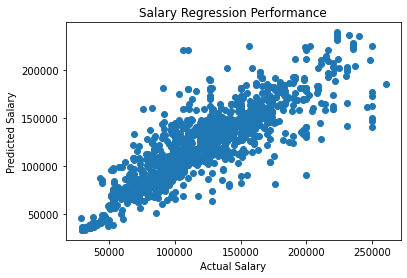

In [25]:
plt.scatter(y_test, preds)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Salary Regression Performance')
plt.show()

# Adding Text Data

The three potential text columns are Title, Certifications, and ContentDescription. Because ContentDescription is probably noisiest, let's start with Title and Certifications. Even though we already tried using Certifications as a categorical variable, the large number of unique values makes me think it may be better as text features.

In [26]:
title = df['Title']
content = df['ContentDescription']
certs = df['Certifications']
df_categorical = df_categorical.drop('Certifications', axis=1)
df_categorical.head()

,Poster,LocationState,JobType,EducationLevel,OccupationFunction,Occupation2Name,Occupation6Name,Occupation8Name,YearsofExperience
0,Cedars-Sinai,CA,"Permanent,Full-Time",Bachelor's Degree,Science / R&D,"Life, Physical, and Social Science Occupation",Biological Technicians,Biological Technicians,0 to 2
4,Cedars-Sinai,CA,"Permanent,Full-Time",Bachelor's Degree,Finance / Accounting,Business and Financial Operations Occupations,Accountants and Auditors,Accountants,8+
5,PIH Health,CA,"Permanent,Full-Time,Part-Time",GED/High School,Sales / Biz. Development,Office and Administrative Support Occupations,Customer Service Representatives,Patient Representatives,0 to 2
7,Amgen,MA,"Permanent,Full-Time",Bachelor's Degree,Manufacturing / Resources,Management Occupations,Industrial Production Managers,Industrial Production Managers,8+
8,CRISPR Therapeutics AG,MA,"Permanent,Full-Time",Bachelor's Degree,Science / R&D,Computer and Mathematical Occupations,Statisticians,Clinical Data Managers,3 to 7


- Wrote a function in an external file to clean text. This function:
    - lowercases text
    - removes punctuation, special characters, and numbers
    - removes stopwords
    - stems or lemmatizes the tokens

### Adding Title Variable



In [27]:
vectorizers = [CountVectorizer, TfidfVectorizer]
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

stemmers = [None, 'stem', 'lemmatize']


for vectorizer in vectorizers:
    for stem in stemmers:
        vec = vectorizer()
        
        if stem is None:
            title = [clean_text(t) for t in title]
        elif stem == 'stem':
            title = [clean_text(t, stemmer=stemmer) for t in title]
        elif stem == 'lemmatize':
            title = [clean_text(t, lemmatizer=lemmatizer) for t in title]

        title_vecs = vec.fit_transform(title)
        features = vec.get_feature_names_out()
        title_vecs = title_vecs.todense()
        title_vec_df = pd.DataFrame(title_vecs, columns=features)

        df_categorical_dummy = pd.get_dummies(df_categorical)
        df_categorical_dummy = df_categorical_dummy.reset_index(drop=True)

        df_with_title = pd.concat([df_categorical_dummy, title_vec_df], axis=1)


        X_train, X_test, y_train, y_test = train_test_split(df_with_title, salary, test_size = .3, random_state = 10)
        rf = RandomForestRegressor(random_state=10)
        rf.fit(X_train, y_train)
        preds = rf.predict(X_test)
        r2 = r2_score(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        print(f'Vectorizer: {vectorizer}, Stemmer: {stem}')
        print(f'R2 Score: {r2}, MSE: {mse}')




Vectorizer: <class 'sklearn.feature_extraction.text.CountVectorizer'>, Stemmer: None
R2 Score: 0.767877209168007, MSE: 450681841.9688387
Vectorizer: <class 'sklearn.feature_extraction.text.CountVectorizer'>, Stemmer: stem
R2 Score: 0.7713371026285217, MSE: 443964228.6219901
Vectorizer: <class 'sklearn.feature_extraction.text.CountVectorizer'>, Stemmer: lemmatize
R2 Score: 0.7716029932195996, MSE: 443447984.3492083
Vectorizer: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, Stemmer: None
R2 Score: 0.7742260047270191, MSE: 438355232.99363405
Vectorizer: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, Stemmer: stem
R2 Score: 0.7748633788080104, MSE: 437117728.8096858
Vectorizer: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, Stemmer: lemmatize
R2 Score: 0.7754937947339845, MSE: 435893734.3466425


- By adding the title variable, and selecting the best vectorizer and stemming strategy, we improve from R2 = .741 to .775

### Add Certification as Text

In [27]:
vectorizers = [CountVectorizer, TfidfVectorizer]
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

stemmers = [None, 'stem', 'lemmatize']


for vectorizer in vectorizers:
    for stem in stemmers:
        vec = vectorizer()
        
        if stem is None:
            cert = [clean_text(c) for c in certs]
        elif stem == 'stem':
            cert = [clean_text(c, stemmer=stemmer) for c in certs]
        elif stem == 'lemmatize':
            cert = [clean_text(c, lemmatizer=lemmatizer) for c in certs]
        
        cert_vec = vectorizer()
        cert_vecs = cert_vec.fit_transform(cert)
        features = cert_vec.get_feature_names_out()
        cert_vecs = cert_vecs.todense()
        cert_vec_df = pd.DataFrame(cert_vecs, columns=features)

        df_categorical_dummy = pd.get_dummies(df_categorical)
        df_categorical_dummy = df_categorical_dummy.reset_index(drop=True)

        df_with_cert = pd.concat([df_categorical_dummy, cert_vec_df], axis=1)


        X_train, X_test, y_train, y_test = train_test_split(df_with_cert, salary, test_size = .3, random_state = 10)
        rf = RandomForestRegressor(random_state=10)
        rf.fit(X_train, y_train)
        preds = rf.predict(X_test)
        r2 = r2_score(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        print(f'Vectorizer: {vectorizer}, Stemmer: {stem}')
        print(f'R2 Score: {r2}, MSE: {mse}')




Vectorizer: <class 'sklearn.feature_extraction.text.CountVectorizer'>, Stemmer: None
R2 Score: 0.7370568651786301, MSE: 510521590.3600213
Vectorizer: <class 'sklearn.feature_extraction.text.CountVectorizer'>, Stemmer: stem
R2 Score: 0.7376358056175505, MSE: 509397538.97985446


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\doac\.virtualenvs\vertex-9-Ud9Yaa\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\doac\AppData\Local\Temp\1/ipykernel_27632/2863601595.py", line 33, in <module>
    rf.fit(X_train, y_train)
  File "C:\Users\doac\.virtualenvs\vertex-9-Ud9Yaa\lib\site-packages\sklearn\ensemble\_forest.py", line 442, in fit
    trees = Parallel(
  File "C:\Users\doac\.virtualenvs\vertex-9-Ud9Yaa\lib\site-packages\joblib\parallel.py", line 1046, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\doac\.virtualenvs\vertex-9-Ud9Yaa\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\doac\.virtualenvs\vertex-9-Ud9Yaa\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\doac\.virtualenvs\vertex-9-Ud

TypeError: object of type 'NoneType' has no len()

In [ ]:
title = [clean_text(t, lemmatizer=lemmatizer) for t in title]
vec = TfidfVectorizer()
title_vecs = vec.fit_transform(title)
features = vec.get_feature_names_out()
title_vecs = title_vecs.todense()
title_vec_df = pd.DataFrame(title_vecs, columns=features)

df_categorical['Certifications'] = certs

df_categorical_dummy = pd.get_dummies(df_categorical)
df_categorical_dummy = df_categorical_dummy.reset_index(drop=True)

df_with_title = pd.concat([df_categorical_dummy, title_vec_df], axis=1)


X_train, X_test, y_train, y_test = train_test_split(df_with_title, salary, test_size = .3, random_state = 10)
rf = RandomForestRegressor(random_state=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
print(f'Vectorizer: {vectorizer}, Stemmer: {stem}')
print(f'R2 Score: {r2}, MSE: {mse}')



- Seems certifications is better as a categorical variable because we see a slight drop in r2. It may not be significant, but treating it as a categorical variable also allows it to train faster.

- All together, our r2 score to beat is .77596

## Adding ContentDescription

In [ ]:
content_clean = [clean_text(c, lemmatizer=lemmatizer) for c in content]

vec = TfidfVectorizer(min_df=2, max_df=.5)
content_vecs = vec.fit_transform(content_clean)
features = vec.get_feature_names_out()
content_vecs = content_vecs.todense()
content_vec_df = pd.DataFrame(content_vecs, columns=features)

df_categorical['Certifications'] = certs


df_with_content = pd.concat([df_with_title, content_vec_df], axis=1)


X_train, X_test, y_train, y_test = train_test_split(df_with_content, salary, test_size = .3, random_state = 10)
rf = RandomForestRegressor(random_state=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
print(f'Vectorizer: {vectorizer}, Stemmer: {stem}')
print(f'R2 Score: {r2}, MSE: {mse}')

- We see a drop in performance when adding ContentDescription. This makes sense because when looking at the ContentDescription column, there is a lot of noise. Intuitively, you wouldn't expect the job description content to improve predictive power of a salary model on top of the features we already have, because a lot of the info in the description is already in our feature set. However, for the sake of NLP, let's play around with this variable and see what we can do.

## Exploring the ContentDescription Column

In [ ]:
tsne = TSNE(perplexity=50)
embs = tsne.fit_transform(content_vec_df)


In [ ]:
px.scatter(df, x=embs[:,0], y=embs[:,1], hover_data=['Title', 'Poster', 'OccupationFunction'], color='SalaryAnnualEst')

In [ ]:
pca = PCA(n_components=20)
pcs = pca.fit_transform(content_vec_df)
px.scatter_3d(df, x=pcs[:,0], y=pcs[:,1], z=pcs[:,2], hover_data=['Title'], color='OccupationFunction')

# Word Embeddings

In [ ]:
content_tokens = [clean_text(cont, lemmatizer=lemmatizer, return_tokenized=True) for cont in content]
model = Word2Vec(content_tokens, min_count=1)

In [ ]:
w2v_embs = [get_embs(cont, model, lemmatizer) for cont in content]

In [ ]:
w2v_embs = np.array(w2v_embs)
tsne = TSNE(perplexity=50)
embs = tsne.fit_transform(w2v_embs)
px.scatter(df, x=embs[:,0], y=embs[:,1], hover_data=['Title', 'Poster', 'OccupationFunction'], color='SalaryAnnualEst')

- Averaged word embeddings don't seem to carry that much salary information either.

In [ ]:
w2v_df = pd.DataFrame(w2v_embs)
df_with_content = pd.concat([df_with_title, w2v_df], axis=1)


X_train, X_test, y_train, y_test = train_test_split(df_with_content, salary, test_size = .3, random_state = 10)
rf = RandomForestRegressor(random_state=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
print(f'Vectorizer: {vectorizer}, Stemmer: {stem}')
print(f'R2 Score: {r2}, MSE: {mse}')

### BERT Embeddings

In this next section, I investigate BERT embeddings for the ContentDescription column. Because of my computer's limitations, I ran BERT on the cloud, getting output embeddings for each job description using a pre-trained DistilBert model. I then pickled the embeddings for use locally.

In [30]:
bert_embs = pickle.load(open('./BERT_embeddings/embs_untrained.pkl', 'rb'))
bert_embs = np.array(bert_embs)
bert_embs = bert_embs.reshape(bert_embs.shape[0], bert_embs.shape[2])

In [ ]:
tsne = TSNE(perplexity=50)
embs = tsne.fit_transform(bert_embs)
px.scatter(df, x=embs[:,0], y=embs[:,1], hover_data=['Title', 'Poster', 'OccupationFunction'], color='SalaryAnnualEst')

In [ ]:
px.scatter(df, x=embs[:,0], y=embs[:,1], hover_data=['Title', 'Poster', 'OccupationFunction'], color='Occupation2Name')

- Pre-trained BERT embeddings don't seem to have any association with salary level. The embeddings seem to capture information about the industry or job roles rather than salary.

### Trained BERT Embeddings

In this next section, I use BERT embeddings from a model that I fine-tuned on salary prediction, as framed as a multiclass classification problem. The salary target variable was binned into 3 bins based on percentile (0, 33, 66) and the model used the ContentDescription text to try to classify each job into the appropriate salary bin. This was done on the cloud, where I saved the trained embeddings to a pkl file.

In [31]:
bert_trained_embs = pickle.load(open('./BERT_embeddings/trained_embeddings_full.pkl', 'rb'))
bert_trained_embs = np.array(bert_trained_embs)
bert_trained_embs = bert_trained_embs.reshape(bert_trained_embs.shape[0], bert_trained_embs.shape[2])

In [ ]:
tsne = TSNE(perplexity=30)
embs = tsne.fit_transform(bert_trained_embs)
px.scatter(df, x=embs[:,0], y=embs[:,1], color='SalaryAnnualEst')


- Fine-tuning BERT on our dataset and problem resulted in some strange structure in the TSNE plot. It does however look like the model learned to relate job description to salary, since we now see more like-colored points clustered near each other.

In [ ]:
bert_df = pd.DataFrame(bert_trained_embs)

df_categorical = df_categorical.reset_index(drop=True)
salary = salary.reset_index(drop=True)

title = [clean_text(t, lemmatizer=lemmatizer) for t in title]
vec = TfidfVectorizer()
title_vecs = vec.fit_transform(title)
features = vec.get_feature_names_out()
title_vecs = title_vecs.todense()
title_vec_df = pd.DataFrame(title_vecs, columns=features)

df_categorical['Certifications'] = certs

df_categorical_dummy = pd.get_dummies(df_categorical)
df_categorical_dummy = df_categorical_dummy.reset_index(drop=True)

df_with_title = pd.concat([df_categorical_dummy, title_vec_df, bert_df], axis=1)


X_train, X_test, y_train, y_test = train_test_split(df_with_title, salary, test_size = .3, random_state = 10)
rf = RandomForestRegressor(random_state=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
print(f'Vectorizer: {vectorizer}, Stemmer: {stem}')
print(f'R2 Score: {r2}, MSE: {mse}')



#### Visualizing trained BERT embedding PCs

In [ ]:
pca = PCA(n_components=20)
pcs = pca.fit_transform(bert_trained_embs)

In [ ]:
px.scatter_3d(df, x=pcs[:,0], y=pcs[:,1], z=pcs[:,4], hover_data=['Title'], color='SalaryAnnualEst')

#### Try only using first PC of trained BERT embedding

In [ ]:
pcs = pcs[:,[0]]
bert_df = pd.DataFrame(pcs)

df_categorical = df_categorical.reset_index(drop=True)
salary = salary.reset_index(drop=True)

title = [clean_text(t, lemmatizer=lemmatizer) for t in title]
vec = TfidfVectorizer()
title_vecs = vec.fit_transform(title)
features = vec.get_feature_names_out()
title_vecs = title_vecs.todense()
title_vec_df = pd.DataFrame(title_vecs, columns=features)

df_categorical['Certifications'] = certs

df_categorical_dummy = pd.get_dummies(df_categorical)
df_categorical_dummy = df_categorical_dummy.reset_index(drop=True)

df_with_title = pd.concat([df_categorical_dummy, title_vec_df, bert_df], axis=1)


X_train, X_test, y_train, y_test = train_test_split(df_with_title, salary, test_size = .3, random_state = 10)
rf = RandomForestRegressor(random_state=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
print(f'Vectorizer: {vectorizer}, Stemmer: {stem}')
print(f'R2 Score: {r2}, MSE: {mse}')



- A better result than using all the embeddings, but still not as good as not using ContentDescription
- While there is a lot of info in ContentDescription, there is probably too much noise as it relates to salary to get a predictive boost using it for out model

# Conclusions

Our best model was one that combined text and categorical data, with the text data coming from the Title column, which added predictive power to our model. This makes sense intuitively, because we would expect to be able to predict salary at least somewhat from a job title. On a single train-test-split, this model achieved an R2 score of 0.7764. 

#### Next steps

In this analysis, I only used a random forest model. This is mostly because due to time constraints, I wanted to focus on feature engineering and data-centric approaches to improving model performance. However, my next steps would be to try some other model types. Maybe XGBoost, maybe neural networks. 

I'd also like to take steps to productionize this model. For example, I'd want to talk to stakeholders such as HR people who would likely be using the model. I'd want to get error tolerances and figure out the best way to present the model's predictions. Should it be a discrete prediction of salary, or a range? My intuition is the latter. Then, I'd start gathering requirements and scoping out a web application or some other platform to present the model to the end users.

# Demo: function to predict salary from a novel job posting

In [ ]:
entry_level_job = {
    'Poster': 'Biogen',
    'Title': 'Associate Scientist I',
    'LocationState': 'MA',
    'JobType': 'Permanent,Full-Time',
    'EducationLevel': "Bachelor's Degree",
    'OccupationFunction': 'Science / R&D',
    'Occupation2Name': 'Life, Physical, and Social Science Occupation',
    'Occupation6Name': 'Biochemists and Biophysicists',
    'Occupation8Name': 'Biochemists and Biophysicists',
    'YearsofExperience': '0 to 2',
    'Certifications': 'None'
}


experienced_job = {
    'Poster': 'Merck',
    'Title': 'Senior Computer Engineer III',
    'LocationState': 'MA',
    'JobType': 'Permanent,Full-Time',
    'EducationLevel': "Master's Degree",
    'OccupationFunction': 'Information Technology',
    'Occupation2Name': 'Computer and Mathematical Occupations',
    'Occupation6Name': 'Software Developers, Applications',
    'Occupation8Name': 'Software Developers, Applications',
    'YearsofExperience': '8+',
    'Certifications': 'None'
}



In [ ]:
salary_model = SalaryModel('./model_artifacts')

lemmatizer = WordNetLemmatizer()

entry_level_features = salary_model.preprocess(entry_level_job, lemmatizer)
entry_level_prediction = salary_model.predict(entry_level_features)

exp_features = salary_model.preprocess(experienced_job, lemmatizer)
exp_prediction = salary_model.predict(exp_features)

print(f'The entry-level scientist job has a predicted ${entry_level_prediction[0]} salary.')
print(f'The experienced software engineer job has a predicted ${exp_prediction[0]} salary.')